## Handle Imports

In [172]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import pydicom
import glob
import os

## Config Variables

In [166]:
BASE_IMG_DIR = "data/"

EPOCHS = 20

RANDOM_SEED = 42

TEST_SPLIT = 0.2

In [154]:
def info(msg):
    print(f"[INFO] {msg}\n")

In [155]:
df = pd.read_excel("Stroke _DCM _Train_Labels.xlsx")

## Remove unneeded rows and rename columns

In [156]:
# Drop second row and last row
df.drop(index=df.index[-1], axis=0, inplace=True)
df.drop(index=df.index[0], axis=0, inplace=True)

In [157]:
df.rename(columns = {'SERIES': "Positive", "Unnamed: 4": "TP", "Unnamed: 5": "Negative"}, inplace = True)

In [158]:
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,26 to 44,19,31
2,2,STP22,50.0,26 to 46,21,29
3,3,STP23,50.0,26 to 42,17,33
4,4,STP24,50.0,26 to 46,21,29
5,5,STP25,50.0,26 to 45,20,30


## Create functions to generate image ranges for the data frame

In [159]:
def resolve_to_range(txt):
    txt = txt.split(",")
    _l = []
    
    for i in txt:
        a, b = [int(v) for v in i.split("to")]
        
        for j in range(a, b+1):
            _l.append(j)
            
    return _l

## Convert Positive column to have individual positive numbers

In [160]:
df.Positive = df.Positive.apply(resolve_to_range)
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",19,31
2,2,STP22,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
3,3,STP23,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",17,33
4,4,STP24,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
5,5,STP25,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",20,30


## Create new DataFrame holding the ImageWise Data

In [161]:
dataset = {"Images": [], "Tumour": []}

for i in range(1, df.shape[0]+1):
    fn = df["IMAGE NAME"][i]
    pos_l = df.Positive[i]
    
    files = os.listdir(BASE_IMG_DIR + fn)
    files.remove("studyXml.xml")
    
    for index, f in enumerate(files):
        dataset["Images"].append(f"{BASE_IMG_DIR}{fn}/{f}")
        if index in pos_l:
            dataset["Tumour"].append(1)
        else:
            dataset["Tumour"].append(0)

info("Total No. of Positive Samples: " + str(dataset["Tumour"].count(1)))
info("Total No. of Negative Samples: " + str(dataset["Tumour"].count(0)))

[INFO] Total No. of Positive Samples: 2108

[INFO] Total No. of Negative Samples: 3192



## Load the cleaned data into a new DataFrame

In [162]:
data_df = pd.DataFrame(dataset)
data_df.head()

,Images,Tumour
0,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
1,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
2,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
3,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
4,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0


## Load the images and convert them into a Numpy array

In [163]:
image_data = []
target = list(data_df.Tumour)

In [164]:
for fn in data_df.Images:
    image = pydicom.read_file(fn).pixel_array
    
    # Normalise the Image values between 0.0 and 1.0
    image = image - np.min(image)
    image = image / np.max(image)
    
    image_data.append(image)

## Plot random images

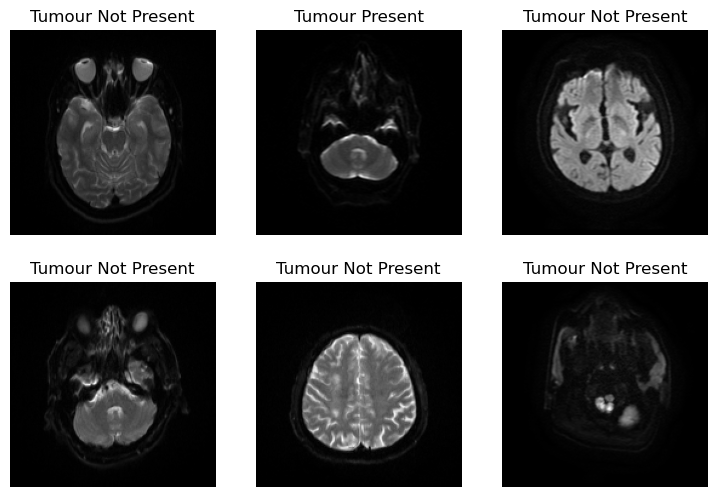

In [165]:
random_indexes = random.sample(range(len(image_data)), k=6)

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

for (idx, c_ax) in zip(random_indexes, axs.flatten()):
    c_ax.imshow(image_data[idx], cmap="gray")
    if target[idx] == 1:
        title = "Tumour Present"
    else:
        title = "Tumour Not Present"
    c_ax.set_title(title)
    c_ax.axis("off")

In [174]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=target)